# Pneumonia Detection from Chest X-ray images using CNN

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pneumonia-Detection-from-Chest-X-ray-images-using-CNN" data-toc-modified-id="Pneumonia-Detection-from-Chest-X-ray-images-using-CNN-1">Pneumonia Detection from Chest X-ray images using CNN</a></span></li><li><span><a href="#import-the-libraries" data-toc-modified-id="import-the-libraries-2">import the libraries</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#preview-some-imgages" data-toc-modified-id="preview-some-imgages-2.0.1">preview some imgages</a></span></li></ul></li></ul></li><li><span><a href="#Create-the-CNN-model" data-toc-modified-id="Create-the-CNN-model-3">Create the CNN model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#create-class-weights" data-toc-modified-id="create-class-weights-3.0.1">create class weights</a></span></li></ul></li><li><span><a href="#model" data-toc-modified-id="model-3.1">model</a></span></li><li><span><a href="#fitting-without-class-weights" data-toc-modified-id="fitting-without-class-weights-3.2">fitting without class weights</a></span><ul class="toc-item"><li><span><a href="#save-model-and-history" data-toc-modified-id="save-model-and-history-3.2.1">save model and history</a></span></li><li><span><a href="#plot-training-and-validation-accuracy" data-toc-modified-id="plot-training-and-validation-accuracy-3.2.2">plot training and validation accuracy</a></span></li></ul></li><li><span><a href="#model-with-weights" data-toc-modified-id="model-with-weights-3.3">model with weights</a></span><ul class="toc-item"><li><span><a href="#save-model-with-weights" data-toc-modified-id="save-model-with-weights-3.3.1">save model with weights</a></span></li><li><span><a href="#plot-accuracy-loss-for-model-with-weights" data-toc-modified-id="plot-accuracy-loss-for-model-with-weights-3.3.2">plot accuracy loss for model with weights</a></span></li></ul></li></ul></li><li><span><a href="#metrics" data-toc-modified-id="metrics-4">metrics</a></span><ul class="toc-item"><li><span><a href="#load-saved-model" data-toc-modified-id="load-saved-model-4.1">load saved model</a></span></li><li><span><a href="#import-test-files" data-toc-modified-id="import-test-files-4.2">import test files</a></span></li></ul></li><li><span><a href="#compare-images-with-prediction" data-toc-modified-id="compare-images-with-prediction-5">compare images with prediction</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#normal-images" data-toc-modified-id="normal-images-5.0.1">normal images</a></span></li><li><span><a href="#PNEUMONIA-images" data-toc-modified-id="PNEUMONIA-images-5.0.2">PNEUMONIA images</a></span></li></ul></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-6">Conclusion</a></span></li></ul></div>

# import the libraries

In [23]:
import os,shutil,glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPool2D,BatchNormalization,Dropout,SeparableConv2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping


All the images are in three directories. 
1. train
2. validaion
3. test

Each of them has two directories "NORMAL" and "PNEUMONIA".

In [4]:
dir_list = ['test','train','val']
categories = ['NORMAL',"PNEUMONIA"]
for d in dir_list:
    for c in categories:
        dc_path = os.path.join("chest_xray",d,c)
        print(f" Number of images in {d} and subdir {c} are {len(os.listdir(dc_path))}")

 Number of images in test and subdir NORMAL are 234
 Number of images in test and subdir PNEUMONIA are 390
 Number of images in train and subdir NORMAL are 1341
 Number of images in train and subdir PNEUMONIA are 3875
 Number of images in val and subdir NORMAL are 8
 Number of images in val and subdir PNEUMONIA are 8


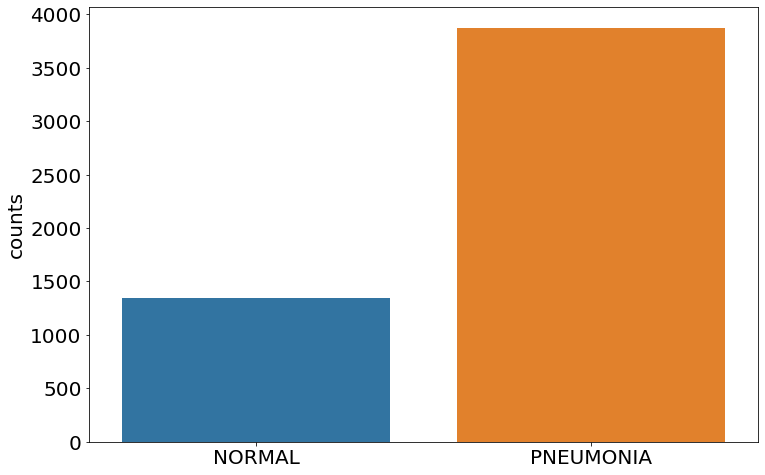

In [148]:
normal_train_count = len(os.listdir(train_dir+"/NORMAL"))
pneumonia_train_count = len(os.listdir(train_dir+"/PNEUMONIA"))

count_df = pd.DataFrame([{'NORMAL':normal_train_count,"PNEUMONIA":pneumonia_train_count}])

plt.rc('font',size=20)
plt.figure(figsize=[12,8])
sns.barplot(data=count_df)
plt.ylabel('counts')

save_fig_path = os.path.join("image_count.png")
plt.savefig(save_fig_path,facecolor='white', transparent=False,dpi=150)

clearly this shows Normal and Pneumonia image numers are not of same values. Infected images are three times more than the normal ones.

In [6]:
train_dir = "chest_xray/train"
test_dir = 'chest_xray/test'
val_dir = "chest_xray/val"

### preview some imgages

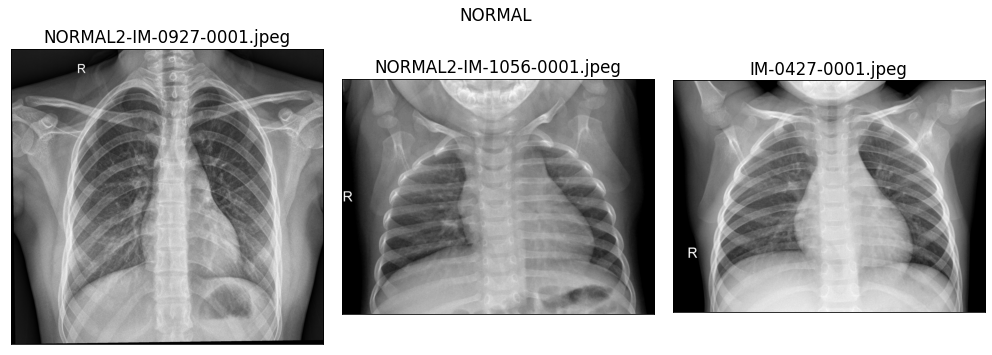

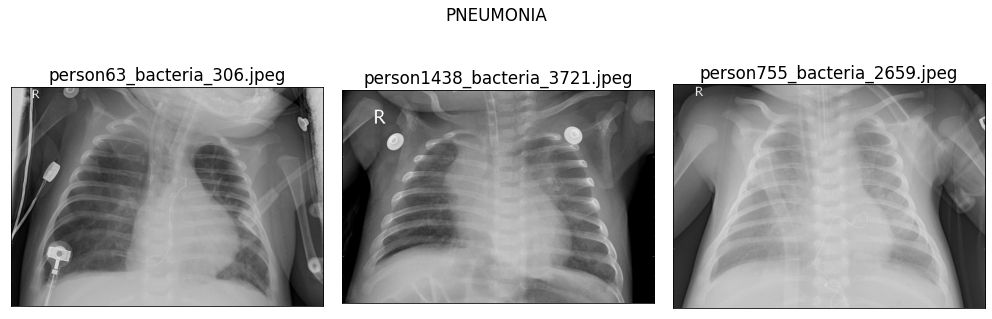

In [114]:
categories = ['NORMAL','PNEUMONIA']
for c in categories:
    image_dir_path = os.path.join(train_dir,c)
    images = glob.glob(image_dir_path+"/*")[:3]
    plt.rc('font',size=14)
    fig,ax = plt.subplots(1,3,figsize = [14,5])
    for i in range(3):
        img = mpimg.imread(images[i])
        ax[i].imshow(img,cmap='gray')
        ax[i].title.set_text(os.path.basename(images[i]))
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.suptitle(c)
    plt.tight_layout()
    
    save_fig_path = os.path.join(c+".png")
    plt.savefig(save_fig_path,facecolor='white', transparent=False,dpi=150)
    plt.show()
    print("\n")



In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

In [9]:
training_set = train_datagen.flow_from_directory(directory=train_dir,
                                                target_size=(128,128),
                                                batch_size=32,
                                                # color_mode = 'grayscale',
                                                class_mode='binary',
                                                shuffle=True)

Found 5216 images belonging to 2 classes.


In [10]:
training_set.image_shape

(128, 128, 3)

In [11]:
validation_set = train_datagen.flow_from_directory(directory=test_dir,
                                                target_size=(128,128),
                                                batch_size=32,
                                                # color_mode = 'grayscale',
                                                class_mode='binary')

Found 624 images belonging to 2 classes.


# Create the CNN model

### create class weights

In [12]:
print("training_normal",len(os.listdir(train_dir+"/NORMAL")))
print("training_infected",len(os.listdir(train_dir+"/PNEUMONIA")))

training_normal 1341
training_infected 3875


the data set is imbalanced. I have to add weights.

In [13]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [14]:
normal_train_count = len(os.listdir(train_dir+"/NORMAL"))
pneumonia_train_count = len(os.listdir(train_dir+"/PNEUMONIA"))
total_train_count = normal_train_count+pneumonia_train_count

weight_for_0 = (1/normal_train_count)*(total_train_count)/2.0
weight_for_1 = (1/pneumonia_train_count)*(total_train_count)/2.0
class_weight = {0:weight_for_0,1:weight_for_1}
print(class_weight)

{0: 1.9448173005219984, 1: 0.6730322580645162}


## model

Let's create the CNN model

In [15]:
model_01 = Sequential([
            SeparableConv2D(filters = 16, kernel_size=(3,3),
                            padding = 'same',activation = 'relu',
                            input_shape = training_set.image_shape), # input shape should be image_shape
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 32,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 64,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 128,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 256,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),
                    Dropout(0.2),


                    Flatten(),
                    Dense(512,activation='relu'),
                    Dropout(0.7),

                    Dense(128,activation='relu'),
                    Dropout(0.5),

                    Dense(64,activation='relu'),
                    Dropout(0.3),

                    Dense(1,activation='sigmoid')]
                    )


print(model_01.summary())

model_01.compile(loss='binary_crossentropy',
              optimizer = 'adam',
             metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d (Separable  (None, 128, 128, 16)     91        
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 64, 64, 32)       688       
 leConv2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0

2022-04-26 18:35:37.605014: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## fitting without class weights

In [ ]:

project_dir_path = "."
check_point_path = os.path.join(project_dir_path,"best_weights_pneumonia.hdf5")

checkpoint = ModelCheckpoint(filepath  = check_point_path, 
                             save_best_only   = True, 
                             save_weights_only  =True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, patience=2, 
                              verbose=2, mode='max')

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.1, patience=1, 
                           mode='min')




fitting_01 = model_01.fit_generator(training_set,
                             validation_data=(validation_set),
                              epochs=10,
                              steps_per_epoch = len(training_set),
                              validation_steps=len(validation_set),
                              callbacks=[lr_reduce,checkpoint]
                            #   class_weight=class_weight
                              )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
163/163 [==============================] - 99s 537ms/step - loss: 0.7514 - accuracy: 0.7811 - val_loss: 0.9534 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 86s 530ms/step - loss: 0.3028 - accuracy: 0.8698 - val_loss: 2.8864 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 86s 525ms/step - loss: 0.2652 - accuracy: 0.8984 - val_loss: 5.2042 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 85s 522ms/step - loss: 0.2270 - accuracy: 0.9149 - val_loss: 1.5262 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2039 - accuracy: 0.9285
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 85s 523ms/step - loss: 0.2039 - accuracy: 0.9285 - val_loss: 0.4895 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 6/10
163/163 [=============================

### save model and history

In [ ]:
model_name = "cnn_pneumonia_model_01.h5"
project_dir_path = "."
model_save_path = os.path.join(project_dir_path,model_name)
model_01.save(model_save_path)

In [ ]:
history_df = pd.DataFrame(fitting_01.history)

history_file = "cnn_pneumonia_model_01.csv"
history_save_path = os.path.join(project_dir_path,history_file)
history_df.to_csv(history_save_path)

### plot training and validation accuracy

In [142]:
history_df = pd.read_csv("cnn_pneumonia_model_01.csv")

In [143]:
history_df.index = np.arange(10)+1
# history_df

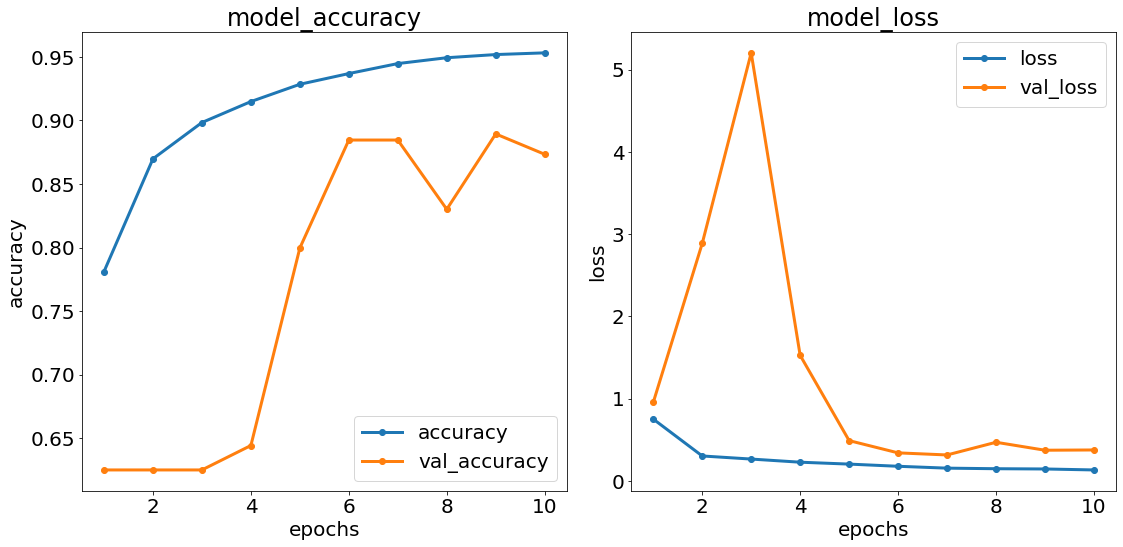

In [144]:
plt.rc('font',size=20)
fig,ax = plt.subplots(1,2,figsize=[16,8])

ax = ax.ravel()


loss_plots = ['loss','val_loss']
acc_plots = ['accuracy','val_accuracy']
y_labels = ['accuracy','loss']
# titles = 

for i,p in enumerate([acc_plots,loss_plots]):
    history_df[p].plot(ax=ax[i],linewidth=3,style = 'o-')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_title('model_'+ y_labels[i])
    ax[i].axes.xaxis.get_major_locator().set_params(integer=True)


plt.tight_layout()
fig_name = os.path.join(project_dir_path,"cnn_pneumonia_model_01.png")
plt.savefig(fig_name,facecolor='white', transparent=False,dpi=150)


Looks like after epoch=4 the accuracy is increased and loss decreased. 

## model with weights

In [ ]:
model_02 = Sequential([


            SeparableConv2D(filters = 16, kernel_size=(3,3),
                            padding = 'same',activation = 'relu',
                            input_shape = training_set.image_shape), # input shape should be image_shape
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 32,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 64,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 128,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),

                    SeparableConv2D(filters = 256,
                                    kernel_size=(3,3),
                                    padding='same',activation='relu'),
                    BatchNormalization(),
                    MaxPool2D(pool_size = (2,2)),
                    Dropout(0.2),


            Flatten(),
            Dense(512,activation='relu'),
            Dropout(0.7),

            Dense(128,activation='relu'),
            Dropout(0.5),

            Dense(64,activation='relu'),
            Dropout(0.3),

            Dense(1,activation='sigmoid')]
            )


print(model_02.summary())

model_02.compile(loss='binary_crossentropy',
              optimizer = 'adam',
             metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_10 (Separa  (None, 128, 128, 16)     91        
 bleConv2D)                                                      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_11 (Separa  (None, 64, 64, 32)       688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)      

In [ ]:
project_dir_path = "."
check_point_path = os.path.join(project_dir_path,"best_weights_pneumonia_with_weights.hdf5")

checkpoint = ModelCheckpoint(filepath  = check_point_path, 
                             save_best_only   = True, 
                             save_weights_only  =True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.3, patience=2, 
                              verbose=2, mode='max')

early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=0.1, patience=1, 
                           mode='min')




fitting_02 = model_02.fit_generator(training_set,
                             validation_data=(validation_set),
                              epochs=10,
                              steps_per_epoch = len(training_set),
                              validation_steps=len(validation_set),
                              callbacks=[lr_reduce,checkpoint],
                              class_weight=class_weight
                              )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
163/163 [==============================] - 99s 596ms/step - loss: 0.9049 - accuracy: 0.6936 - val_loss: 1.0890 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 90s 549ms/step - loss: 0.3669 - accuracy: 0.8405 - val_loss: 3.6041 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - 92s 563ms/step - loss: 0.2883 - accuracy: 0.8825 - val_loss: 7.1852 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 88s 540ms/step - loss: 0.2543 - accuracy: 0.8961 - val_loss: 3.1486 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.2438 - accuracy: 0.9024
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 88s 537ms/step - loss: 0.2438 - accuracy: 0.9024 - val_loss: 0.3988 - val_accuracy: 0.8205 - lr: 0.0010
Epoch 6/10
163/163 [=============================

### save model with weights

In [ ]:
model_name = "cnn_pneumonia_model_02_with_weights.h5"
project_dir_path = "."
model_save_path = os.path.join(project_dir_path,model_name)
model_02.save(model_save_path)

In [ ]:
history_df = pd.DataFrame(fitting_02.history)

history_file = "cnn_pneumonia_model_02_with_weights.csv"
history_save_path = os.path.join(project_dir_path,history_file)
history_df.to_csv(history_save_path)

### plot accuracy loss for model with weights

In [145]:
history_df = pd.read_csv("cnn_pneumonia_model_02_with_weights.csv")

In [146]:
history_df.index = np.arange(10)+1

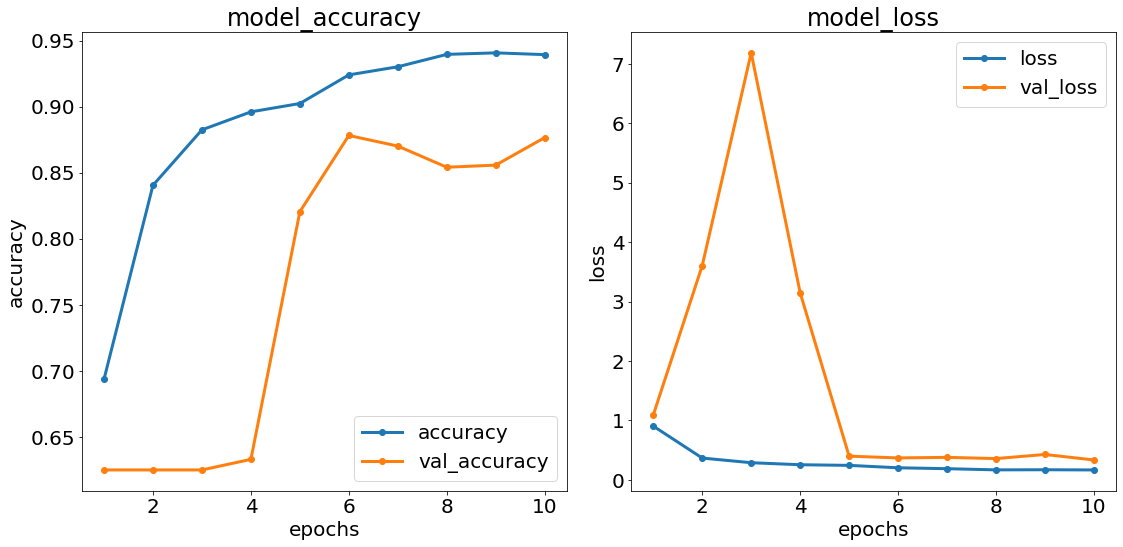

In [147]:
plt.rc('font',size=20)
fig,ax = plt.subplots(1,2,figsize=[16,8])

ax = ax.ravel()

loss_plots = ['loss','val_loss']
acc_plots = ['accuracy','val_accuracy']
y_labels = ['accuracy','loss']

for i,p in enumerate([acc_plots,loss_plots]):
    history_df[p].plot(ax=ax[i],linewidth=3,style = 'o-')
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(y_labels[i])
    ax[i].set_title('model_'+ y_labels[i])
    ax[i].axes.xaxis.get_major_locator().set_params(integer=True)

plt.tight_layout()
fig_name = os.path.join(project_dir_path,"cnn_pneumonia_model_02_weights.png")
plt.savefig(fig_name,facecolor='white', transparent=False,dpi=150)


the effect of class weight seems like very little for this model.

# metrics

## load saved model

In [32]:
project_dir_path = "."
model_name = "cnn_pneumonia_model_02_with_weights.h5"
model_L = load_model(os.path.join(project_dir_path,model_name))

In [33]:
model_L.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 separable_conv2d_10 (Separa  (None, 128, 128, 16)     91        
 bleConv2D)                                                      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 16)       0         
 g2D)                                                            
                                                                 
 separable_conv2d_11 (Separa  (None, 64, 64, 32)       688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_8 (Batc  (None, 64, 64, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 32, 32, 32)      

## import test files

In [66]:
test_df = pd.DataFrame()
image_path = []
image_class = []
image_category = []

all_normal = os.listdir("chest_xray/test/NORMAL")
all_pneumonia = os.listdir("chest_xray/test/PNEUMONIA")
for i in all_normal:
    image_path.append(os.path.join("chest_xray/test/NORMAL",i))
    image_class.append('NORMAL')
    image_category.append(0)

for i in all_pneumonia:
    image_path.append(os.path.join("chest_xray/test/PNEUMONIA",i))
    image_class.append('PNEUMONIA')
    image_category.append(1)

test_df['image_path']=image_path
test_df['image_class']=image_class
test_df['image_category']=image_category


In [67]:
test_df

,image_path,image_class,image_category
0,chest_xray/test/NORMAL/IM-0031-0001.jpeg,NORMAL,0
1,chest_xray/test/NORMAL/IM-0025-0001.jpeg,NORMAL,0
2,chest_xray/test/NORMAL/NORMAL2-IM-0272-0001.jpeg,NORMAL,0
3,chest_xray/test/NORMAL/NORMAL2-IM-0102-0001.jpeg,NORMAL,0
4,chest_xray/test/NORMAL/NORMAL2-IM-0229-0001.jpeg,NORMAL,0
...,...,...,...
619,chest_xray/test/PNEUMONIA/person120_bacteria_5...,PNEUMONIA,1
620,chest_xray/test/PNEUMONIA/person171_bacteria_8...,PNEUMONIA,1
621,chest_xray/test/PNEUMONIA/person109_bacteria_5...,PNEUMONIA,1
622,chest_xray/test/PNEUMONIA/person83_bacteria_41...,PNEUMONIA,1


In [68]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [69]:
test_data_set = test_datagen.flow_from_dataframe(test_df,x_col='image_path',
                                                 target_size=(128,128),
                                                batch_size=1,
                                                class_mode=None,
                                                 shuffle = False)

Found 624 validated image filenames.


In [70]:
test_data_set.batch_size

1

In [71]:
step_size_test = test_data_set.n/test_data_set.batch_size
predictions = model_L.predict_generator(test_data_set,
                                      steps = step_size_test,
                                      verbose = 1)

/var/folders/16/4lq8fhbs4l16hs228x6zv3zw0000gq/T/ipykernel_96231/2042958393.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model_L.predict_generator(test_data_set,


624/624 [==============================] - 10s 16ms/step


In [72]:
accuracy = accuracy_score(test_df['image_category'], np.round(predictions))*100
confusion_matrix_n = confusion_matrix(test_df['image_category'], np.round(predictions))

In [73]:
print(accuracy)
print(confusion_matrix_n)

91.66666666666666
[[200  34]
 [ 18 372]]


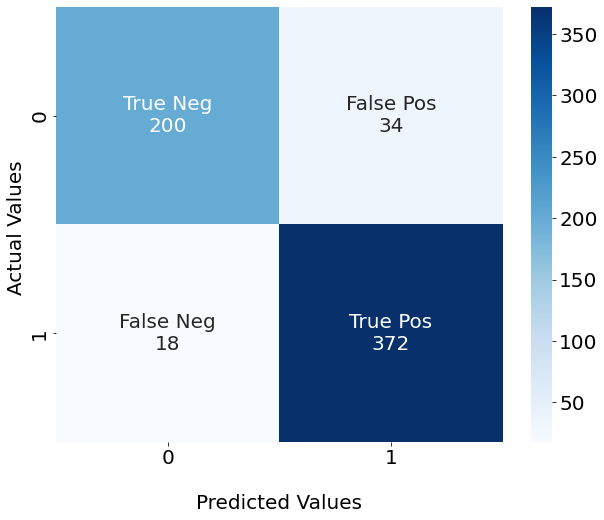

In [77]:
labels = ['True Neg','False Pos','False Neg','True Pos']
cm_values = confusion_matrix_n.flatten()


labels = [f"{v1}\n{v2}" for v1,v2 in zip(labels,cm_values)]
labels = np.asarray(labels).reshape(2,2)

plt.rc('font',size=20)

plt.figure(figsize=[10,8])
ax = sns.heatmap(confusion_matrix_n, annot=labels, fmt='',cmap='Blues')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])
save_fig_path = os.path.join("confusion_matrix.png")
plt.savefig(save_fig_path,facecolor='white', transparent=False,dpi=150)
plt.show()

In [140]:
tn,fp,fn,tp = confusion_matrix_n.flatten()

precision = tp/(tp+fp)
recall    = tp/(tp+fn)
f1_score = 2*precision*recall/(precision+recall)
# acc_2 = (tp+tn)/(tp+tn+fp+fn)
print("Accuracy  = ",round(accuracy,2))
print("Precision = ",round(precision,2))
print("Recall    = ",round(recall,2))
print('f1-score  = ',round(f1_score,2))


Accuracy  =  91.67
Precision =  0.92
Recall    =  0.95
f1-score  =  0.93


# compare images with prediction

In [ ]:
class_dict = {0:'NORMAL',1:'PNEUMONIA'}
pred_class = np.where(predictions>0.5,1,0)
pred_class = pred_class.ravel()

### normal images

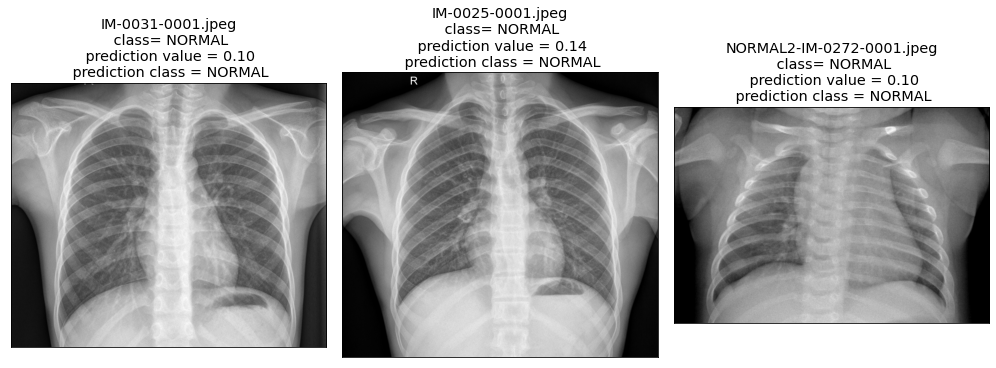

In [150]:
plt.rc('font',size=12)
fig,ax = plt.subplots(1,3,figsize = [14,5])
for i in range(3):
    img_path = test_df.loc[i,"image_path"]
    input_class = test_df.loc[i,"image_class"]
    prediction_i  = predictions[i][0]
    prediction_class = class_dict[pred_class[i]]
    img = mpimg.imread(img_path)
    img_name = os.path.basename(img_path)
    ax[i].imshow(img,cmap='gray')
    ax[i].title.set_text(f"{img_name}\n class= {input_class}\n prediction value = {prediction_i:.2f}\n prediction class = {prediction_class}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()   
save_fig_path = "Normal_predicted.png"
plt.savefig(save_fig_path,facecolor='white', transparent=False,dpi=150)
plt.show()
    #     plt.suptitle(c)
#     plt.tight_layout()

### PNEUMONIA images

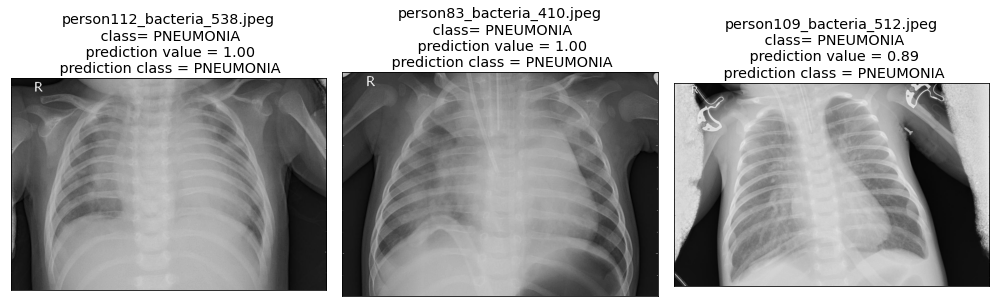

In [149]:
plt.rc('font',size=12)
fig,ax = plt.subplots(1,3,figsize = [14,5])
for i in range(3):
    index = len(test_df)-i-1
    img_path = test_df.loc[index,"image_path"]
    input_class = test_df.loc[index,"image_class"]
    prediction_i  = predictions[index][0]
    prediction_class = class_dict[pred_class[index]]
    img = mpimg.imread(img_path)
    img_name = os.path.basename(img_path)
    ax[i].imshow(img,cmap='gray')
    ax[i].title.set_text(f"{img_name}\n class= {input_class}\n prediction value = {prediction_i:.2f}\n prediction class = {prediction_class}")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()   
save_fig_path = "pneumonia_predicted.png"
plt.savefig(save_fig_path,facecolor='white', transparent=False,dpi=150)
plt.show()

# Conclusion

I have successfully created a model with precision = 0.92 and recall = 0.95.
This model is created from scratch instead of using any transfer learning models.